In [1]:
import gym
import torch
import numpy as np

from gym.wrappers import GrayScaleObservation
from gym.wrappers import ResizeObservation
from gym.wrappers import FrameStack
from gym.wrappers import TransformObservation
import ale_py

import torch
from torch import nn
from torch.functional import F

from matplotlib import pyplot as plt
from collections import deque
import sys
import importlib

from collections import deque
from qnetwork import QNetwork
from agent import Agent
from replay_buffer import ReplayBuffer

In [2]:
env = gym.make('ALE/Pong-v5', render_mode='rgb_array')
done = True
print('Press interrupt to stop execution')
rewards = 0.0
try:
    for step in range(5000):
        if done:
            state = env.reset()
            state, reward, interupted, terminated, info = env.step(env.action_space.sample())
            rewards += reward
            done = interupted or terminated
except KeyboardInterrupt:
    print('Execution Interrupted.')
finally:
    env.close()
print('Total Reward:', rewards)

Press interrupt to stop execution
Total Reward: 0.0


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [3]:

# Structure the environment for processing
env = GrayScaleObservation(env) # Converts the state to grayscale
env = TransformObservation(env, lambda x: x / 255.0)  # scale pixel values to range [0, 1]
env = ResizeObservation(env, 84) # Resizes the state into a 84x84.
env = FrameStack(env, 4) # Stacks 4 frames 



In [4]:
# Observation structure
obs, _ = env.reset()
obs = torch.Tensor(obs).squeeze()
print(obs.shape)

torch.Size([4, 84, 84])


/var/folders/0d/p26013bs7vl7zpbjnjpqyqtm0000gn/T/ipykernel_4577/1567327462.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  obs = torch.Tensor(obs).squeeze()


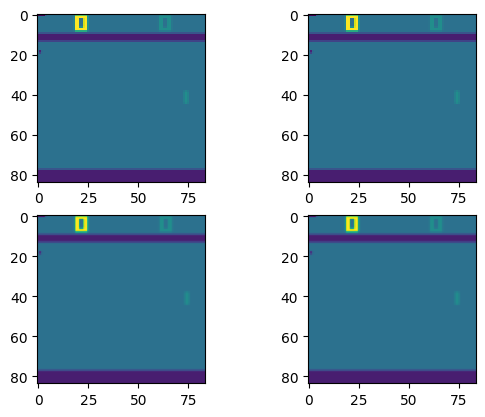

In [5]:
 # Plot the observation
fig, axs = plt.subplots(2, 2)
for idx, ax in enumerate(axs.flatten()):
    ax.imshow(obs[idx])

In [6]:
def roll(state):
    state = np.array(state)
    state = np.rollaxis(state, 2, 0)  
    return state

In [7]:
env.seed(0)
torch.manual_seed(0)
np.random.seed(0)


state_size = (4, 84, 84) # updated state size # ALE/Pong-v5 state size
action_size = env.action_space.n
BUFFER_SIZE = int(1e5) # replay buffer size
BATCH_SIZE = 64
GAMMA = 0.99 # discount factor
TAU = 1e-3 # for soft update of target parameters
LR = 5e-4 # learning rate
UPDATE_EVERY = 4 # how often to update the network
max_t = 1000 # maximum number of timesteps per episode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# training loop
scores = [] 
score_threshold = 21
scores_window = deque(maxlen=100)
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
number_of_episodes = 2000

# Train the agent
for i_episode in range(1, number_of_episodes+1):
    env_info = env.reset()
    state = env_info[0]
    state = roll(state)  
    total_reward = 0
    
    # Decrease epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    
    for t in range(max_t):
        
        action = agent.act(state, epsilon)
        # env_info, reward, done, info, extra = env.step(action)
        env_info, reward, interupted, terminated, info = env.step(action)

        next_state = state
        next_state = roll(next_state)
        print("Shape of the next step in step agent ", state.shape)
        agent.step(state, action, reward, next_state, interupted)
        state = next_state
        total_reward += reward
        
        if interupted:
            break
    
    scores_window.append(total_reward)
    scores.append(total_reward)
    
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
    if np.mean(scores_window) >= score_threshold:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break
        
env.close()

X was  torch.Size([84, 4, 84, 1])
X is  torch.Size([1, 4, 84, 84])
X after conv_forward is  torch.Size([1, 2592])
X after fc_forward is  torch.Size([1, 6])
X was  torch.Size([84, 4, 84, 1])
X is  torch.Size([1, 4, 84, 84])
X after conv_forward is  torch.Size([1, 2592])
X after fc_forward is  torch.Size([1, 6])
X was  torch.Size([84, 4, 84, 1])
X is  torch.Size([1, 4, 84, 84])
X after conv_forward is  torch.Size([1, 2592])
X after fc_forward is  torch.Size([1, 6])
X was  torch.Size([84, 4, 84, 1])
X is  torch.Size([1, 4, 84, 84])
X after conv_forward is  torch.Size([1, 2592])
X after fc_forward is  torch.Size([1, 6])
X was  torch.Size([84, 4, 84, 1])
X is  torch.Size([1, 4, 84, 84])
X after conv_forward is  torch.Size([1, 2592])
X after fc_forward is  torch.Size([1, 6])
X was  torch.Size([84, 4, 84, 1])
X is  torch.Size([1, 4, 84, 84])
X after conv_forward is  torch.Size([1, 2592])
X after fc_forward is  torch.Size([1, 6])
X was  torch.Size([84, 4, 84, 1])
X is  torch.Size([1, 4, 84, 84

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x192960 and 2592x256)